In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor
import models

df = data_tracks.get_tracks() # note: different Xs can be different shapes
df = data_tracks.preprocess(df)
df = data_tracks.add_outcome(df)
n = df.shape[0]

# basic eda

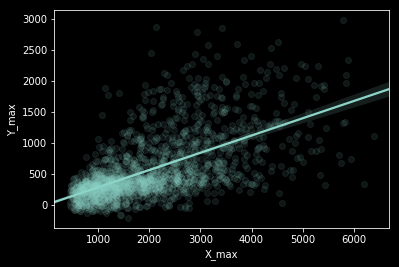

In [45]:
sns.regplot('X_max', 'Y_max', df, scatter_kws={'alpha': 0.1})

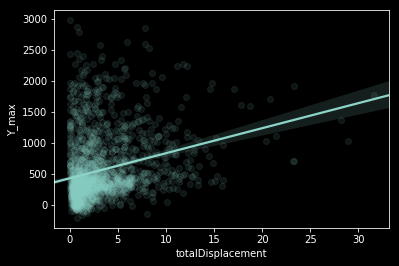

In [25]:
sns.regplot('totalDisplacement', 'Y_max', df, scatter_kws={'alpha': 0.1})

In [34]:
m = RidgeCV(store_cv_values=True)
m.fit(df['X_max'].values.reshape(-1, 1), df['Y_max'].values.reshape(-1, 1), )

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=True)

In [37]:
m.cv_values_[0]

array([[9359.74290596, 9359.74286412, 9359.74244571]])

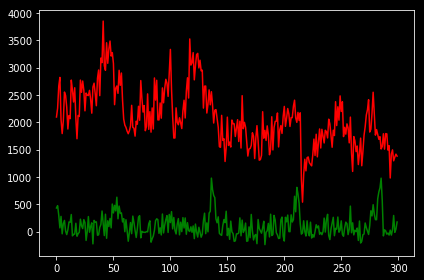

In [38]:
# 0 is the first channel (clathrin)
R, C = 1, 1
# R, C = 5, 5
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    plt.plot(row.X, color='red', label='clathrin')
    plt.plot(row.Y, color='green', label='auxilin')
#     plt.axi('off')
#     plt.legend()

plt.tight_layout()
plt.show()

# fit maxconv

In [21]:
# pad lists with zeros
X = df['X'].values
p = 300
X_mat = np.zeros((n, p)).astype(np.float32)
for i in range(n):
    x = X[i]
    num_timepoints = min(300, len(x))
    X_mat[i, :num_timepoints] = x[:num_timepoints]
X_mat = np.nan_to_num(X_mat)
X_mat -= np.min(X_mat)
X_mat /= np.std(X_mat)
    
Y_max = df['Y_max'].values.astype(np.float32)
Y_max -= np.min(Y_max)
Y_max /= np.std(Y_max) # zero min, stddev 1
# X_feat, Y_max = data.extract_single_pixel_features(X, Y)
# Y_max -= np.min(Y_max) # make all vals positive
# print('shapes', X_feat.shape, Y_max.shape)

# m.fit(X_feat, Y_max)
X_train, X_test, Y_train, Y_test = train_test_split(X_mat, Y_max, test_size=0.33, random_state=42)
# results = cross_validate(m, X_feat, y_max, cv=2, return_train_score=True, return_estimator=True)

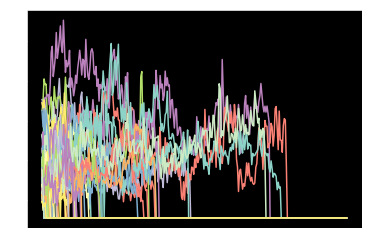

In [22]:
for i in range(100):
    plt.plot(X_train[i])

In [29]:
conv_size = 10
num_channels = 1
dirname = oj('out', f'conv_size={conv_size}_num_channels={num_channels}')
# dirname = 'conv_size=8_num_chanels=30' # conv_size x num_conv
# train_end_cp = TrainEndCheckpoint(dirname='exp1')
# net = NeuralNetClassifier(
#     MyModule, lr=0.5, callbacks=[cp, train_end_cp]
# )

net = NeuralNetRegressor(
    models.MaxConv(num_units=num_channels, kernel_size=conv_size, use_bias=False),
    max_epochs=1000,
    batch_size=1000,
    lr=1e-3,
    iterator_train__shuffle=True,
    optimizer=torch.optim.SGD,
    callbacks=[Checkpoint(dirname=dirname)],
    device='cpu'
)

In [ ]:
# train
net.fit(X_train, Y_train.reshape(-1, 1))
# pkl.dump(net, open( "net_big.pkl", "wb" ))

Re-initializing optimizer.
(10,)
offset 0.15514989


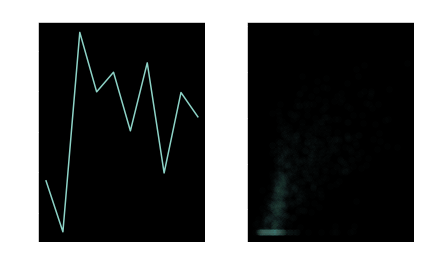

In [31]:
# load trained model and plot
net.initialize() # This is important!
net.load_params(
    f_params=oj(dirname, 'params.pt'), f_optimizer=oj(dirname, 'optimizer.pt'), f_history=oj(dirname, 'history.json')
)


R, C = 1, 2

ws = net.module_.state_dict()['conv1.weight'].cpu().numpy().squeeze()
print(ws.shape)
print('offset', net.module_.state_dict()['offset'].cpu().numpy().squeeze())

plt.subplot(R, C, 1)
plt.title('filters')
plt.plot(ws.T)

plt.subplot(R, C, 2)
preds = net.predict(X_train)
plt.plot(Y_train, preds, 'o', alpha=0.01)
plt.title(f'mse {np.mean(np.square(Y_train - preds)):0.2f} r2 {metrics.r2_score(Y_train, preds):0.2f}')
plt.xlabel('Y')
plt.ylabel('pred')

plt.tight_layout()
plt.savefig(dirname + '.png')
plt.show()

# define events
- take mean, take sigma, define events with a thtrehold

In [32]:
outcome_score = df['outcome_score'].values
outcome = df['outcome'].values
Y = df['Y'].values

# sort for viz
idxs_sort = np.argsort(outcome_score)
Y_sort = Y[idxs_sort]
outcome_sort = outcome[idxs_sort]

num_pos = np.sum(outcome)
num_neg = n - num_pos
print('n', n, 'num negative', num_neg, 'num positive', num_pos)
# plt.hist(outcome.astype(np.int))
# plt.show()

n 1602 num negative 1283 num positive 319


**top and bottom**

In [ ]:
R, C = 4, 5
# plt.figure(dpi=200)
plt.figure(figsize=(9, 8))
idxs = list(range(10)) + list(range(n - 10, n))
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Y_sort[idx], color='blue' if outcome_sort[idx] == 0 else 'orange')
#     plt.axis('off')
plt.tight_layout()
plt.savefig('results/worst_best.pdf')

**around the thresh**

In [ ]:
R, C = 8, 10
# plt.figure(dpi=200)
plt.figure(figsize=(18, 12))
idxs = list(range(num_neg - 40, num_neg + 40)) # let's look at ones in the middle
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Y_sort[idx], color='blue' if outcome_sort[idx] == 0 else 'orange')
#     plt.axis('off')
plt.tight_layout()
plt.savefig('results/outcomes_middle.pdf')

# max classification

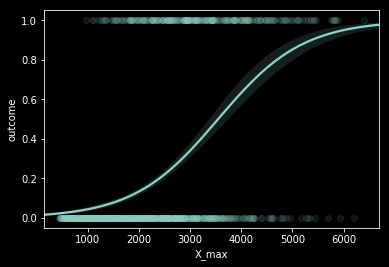

In [35]:
sns.regplot('X_max', 'outcome', df, scatter_kws={'alpha': 0.1}, logistic=True)